# Experiments and Results

------------------------------------

### Set up

In [4]:
from src.optimizers.SAMTrainer import SAMTrainer
from src.optimizers.SimpleTrainer import SimpleTrainer
%load_ext autoreload
%autoreload 2
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

In [5]:
import torch
from src.optimizers.SimpleTrainer import SimpleTrainer
from src.utils.evaluation import evaluate_run
from src.utils import dataset
from matplotlib import pyplot as plt
from src.optimizers.PGDTrainer import PGDTrainer
from src.optimizers.HypercubeTrainer import HypercubeTrainer
from src.utils.evaluation import evaluate_accuracy, evaluate_fgsm_accuracy, evaluate_certified_adv_accuracy
from src.cert import Safebox
from src.optimizers.SAMTrainer import SAMTrainer
from torch.utils.data import DataLoader, Dataset

### Global Constants

In [7]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
N_RUNS = 10

### Utils

##### Plotting


In [8]:
def display_dataset(dataset):
    fig, axs = plt.subplots(1,10)
    fig.set_figwidth(15)
    for i in range(10):
        axs[i].set_axis_off()
        axs[i].imshow(dataset[i][0].numpy().reshape((28,28)), cmap="gray")

##### Evaluation

In [9]:
def evaluate_model(model: torch.nn.Sequential, test_dataset: Dataset, epsilon_fgsm: float = 0.1, epsilon_cert_adv: float = 0.03, data_domain: tuple[float] = (0.0,1.0)) -> list[int]: 
    model = model.to(DEVICE)
    model.eval()
    with torch.no_grad():
        acc = evaluate_accuracy(test_dataset, model, num_samples=len(test_dataset), device=DEVICE)
        fgsm_acc = evaluate_fgsm_accuracy(test_dataset, model, num_samples=len(test_dataset), device=DEVICE, epsilon=epsilon_fgsm, data_domain=data_domain)
        cert_acc = evaluate_certified_adv_accuracy(test_dataset, model, num_samples=len(test_dataset), data_domain=data_domain, device=DEVICE, epsilon=epsilon_cert_adv )
    return [acc, fgsm_acc, cert_acc]

##### Experiment

### Datasets

We evaluate our methodology on the following datasets : MNIST, Fashion-MNIST
##### MNIST

Digit recognition dataset. 

Train Dataset Size:  48000
Test Dataset Size:  12000
Validation Dataset Size:  10000
Validation dataset will be used to select best model during training and handle early stopping. Test dataset will be used for benchmarking. 


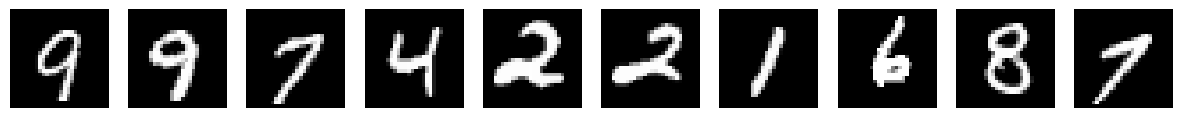

In [13]:
mnist_train_test, mnist_val = dataset.get_mnist_dataset(root="./data")
mnist_train, mnist_test = dataset.split_dataset(mnist_train_test, split_proportion=0.8)
display_dataset(mnist_train)
print("Train Dataset Size: ", len(mnist_train))
print("Test Dataset Size: ", len(mnist_test))
print("Validation Dataset Size: ", len(mnist_val))
print("Validation dataset will be used to select best model during training and handle early stopping. Test dataset will be used for benchmarking. ")

##### FashionMNIST

Clothing classification dataset.

Train Dataset Size:  48000
Test Dataset Size:  12000
Validation Dataset Size:  10000
Validation dataset will be used to select best model during training and handle early stopping. Test dataset will be used for benchmarking. 


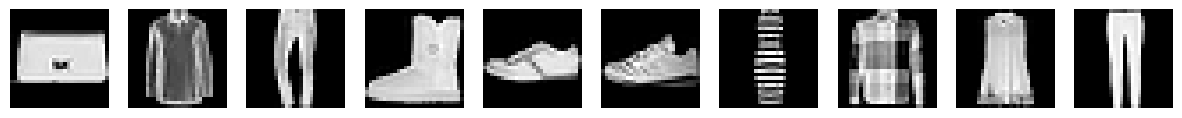

In [14]:
fashion_mnist_train_test, fashion_mnist_val = dataset.get_fashion_mnist_dataset(root="./data")
fashion_mnist_train, fashion_mnist_test = dataset.split_dataset(fashion_mnist_train_test, split_proportion=0.8)
display_dataset(fashion_mnist_train)
print("Train Dataset Size: ", len(fashion_mnist_train))
print("Test Dataset Size: ", len(fashion_mnist_test))
print("Validation Dataset Size: ", len(fashion_mnist_val))
print("Validation dataset will be used to select best model during training and handle early stopping. Test dataset will be used for benchmarking. ")

In [16]:
X, y = next(iter(DataLoader(mnist_train, batch_size=len(mnist_train))))
print(X.max())
print(X.min())
X, y = next(iter(DataLoader(fashion_mnist_train, batch_size=len(fashion_mnist_train))))
print(X.max())
print(X.min())

tensor(1.)
tensor(0.)
tensor(1.)
tensor(0.)


### Model definition

We use a simple 3 layer shallow network to benchmark our methodology. 

In [17]:
def get_model(output_dim=10):
    """Returns a simple CNN model."""
    model = torch.nn.Sequential(
        torch.nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(8, 1, kernel_size=5, stride=1, padding=1),
        torch.nn.ReLU(),
        torch.nn.Flatten(),
        torch.nn.Linear(576, output_dim),
    ).to(DEVICE)
    return model

### Experiments
------------------------
### MNIST


#### Constants

In [3]:
MNIST_EPSILON_FGSM = 0.1
MNIST_EPSILON_CERT_ADV = 0.03
MNIST_DATA_DOMAIN = (0.0, 1.0)

##### ADAM Baseline

In [ ]:
# Setting random seeds for reproducibility
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

def runAdam() -> list[float]:
    adam_model = get_model()        
    trainer = SimpleTrainer(adam_model, device=DEVICE, quiet=True, acc_evalutation_steps=200)
    trainer.train(mnist_train, mnist_val, loss_obj=0.000000000000001, max_iters=6000, batch_size=64, lr=1e-3)
    adam_model = trainer.result()
    evaluate_model(adam_model, mnist_test,epsilon_fgsm=MNIST_EPSILON_FGSM, epsilon_cert_adv=MNIST_EPSILON_CERT_ADV, data_domain=MNIST_DATA_DOMAIN)
means, stds, all_runs = evaluate_run(runAdam, N_RUNS)
print("-"*10, f"Performance of Adam across {N_RUNS} independent runs", "-"*10)
print(f"Train Accuracy : {means[0]:.4f} (std {stds[0]:.4f})")
print(f"Validation Accuracy : {means[1]:.4f} (std {stds[1]:.4f})")
print("All runs : ", all_runs)

In [ ]:
##### PGD Baseline

In [ ]:
# Setting random seeds for reproducibility
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

def runPGD() -> list[float]:
    pgd_model = get_model()        
    trainer = PGDTrainer(pgd_model, quiet=False, device=DEVICE)
    trainer.train(
        mnist_train, mnist_val, 0.0, max_iters=6000, batch_size=64, lr=1e-3, epsilon=0.1, alpha=0.01, num_iters=10
    )
    pgd_model = trainer.result()
    evaluate_model(pgd_model, mnist_test,epsilon_fgsm=MNIST_EPSILON_FGSM, epsilon_cert_adv=MNIST_EPSILON_CERT_ADV, data_domain=MNIST_DATA_DOMAIN)
means, stds, all_runs = evaluate_run(runPGD, N_RUNS)
print("-"*10, f"Performance of Adam across {N_RUNS} independent runs", "-"*10)
print(f"Train Accuracy : {means[0]:.4f} (std {stds[0]:.4f})")
print(f"Validation Accuracy : {means[1]:.4f} (std {stds[1]:.4f})")
print("All runs : ", all_runs)